In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np
import pickle


In [3]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [4]:
df = pd.concat([
    pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet"), 
    pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-02.parquet"),
])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133020 entries, 0 to 64808
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               133020 non-null  int64         
 1   lpep_pickup_datetime   133020 non-null  datetime64[us]
 2   lpep_dropoff_datetime  133020 non-null  datetime64[us]
 3   store_and_fwd_flag     123875 non-null  object        
 4   RatecodeID             123875 non-null  float64       
 5   PULocationID           133020 non-null  int64         
 6   DOLocationID           133020 non-null  int64         
 7   passenger_count        123875 non-null  float64       
 8   trip_distance          133020 non-null  float64       
 9   fare_amount            133020 non-null  float64       
 10  extra                  133020 non-null  float64       
 11  mta_tax                133020 non-null  float64       
 12  tip_amount             133020 non-null  float64   

In [6]:
df["duration"] = (df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"])
df["duration_min"] = df.duration.apply(lambda td: td.total_seconds() / 60)


/home/codespace/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='duration_min', ylabel='Density'>

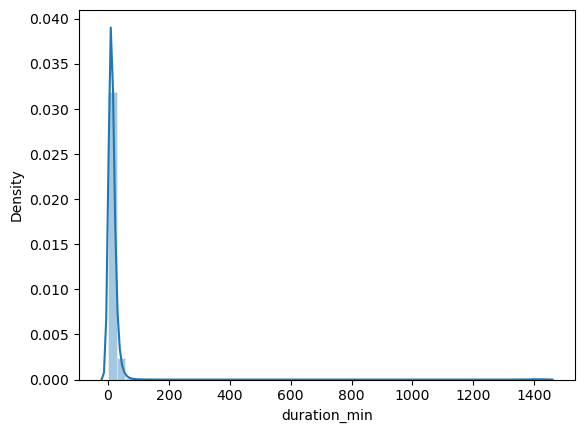

In [7]:
sns.histplot(
    df.duration_min, kde=True, stat="density", bins=50, 
    alpha=.4, edgecolor=(1, 1, 1, .4), kde_kws=dict(cut=3),
)

In [8]:
df.duration_min.describe(percentiles=[0.95, 0.98, 0.99])

count    133020.000000
mean         17.925590
std          72.230551
min           0.000000
50%          11.450000
95%          34.000000
98%          46.250000
99%          58.250000
max        1439.883333
Name: duration_min, dtype: float64

In [9]:
categorical = ["PULocationID", "DOLocationID"]
numerical = ["trip_distance"]

def load_df(paths: list) -> pd.DataFrame:
    df = pd.concat([pd.read_parquet(path) for path in paths])

    df["duration"] = (df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"])
    df["duration_min"] = df.duration.apply(lambda td: td.total_seconds() / 60)
    df = df[(df.duration_min >= 1) & (df.duration_min < 80)]

    df[categorical] = df[categorical].astype("str")
    
    return df
    

In [10]:
df_train = load_df([
    "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet", 
    "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-02.parquet",
])

In [11]:
df_val = load_df(["https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-03.parquet"])

In [12]:
df_train.shape, df_val.shape

((129040, 22), (69799, 22))

In [13]:
len(df_train), len(df_val)

(129040, 69799)

In [14]:
train_dict = df_train[categorical + numerical].to_dict(orient="records")
val_dict = df_val[categorical + numerical].to_dict(orient="records")

In [15]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)


In [16]:
X_train, X_val

(<129040x491 sparse matrix of type '<class 'numpy.float64'>'
 	with 387120 stored elements in Compressed Sparse Row format>,
 <69799x491 sparse matrix of type '<class 'numpy.float64'>'
 	with 209390 stored elements in Compressed Sparse Row format>)

In [17]:
target = "duration_min"
y_train = df_train[target].values
y_val = df_val[target].values

In [18]:
y_train, y_val

(array([11.01666667,  6.76666667,  6.33333333, ..., 17.        ,
        17.        ,  5.        ]),
 array([10.61666667, 10.58333333, 10.58333333, ..., 31.        ,
        22.        , 15.        ]))

In [19]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [20]:
y_pred = lr.predict(X_train)

In [21]:
y_pred_val = lr.predict(X_val)

/tmp/ipykernel_8861/1219225857.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label="prediction")
/home/codespace/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_8861/1219225857.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level fun

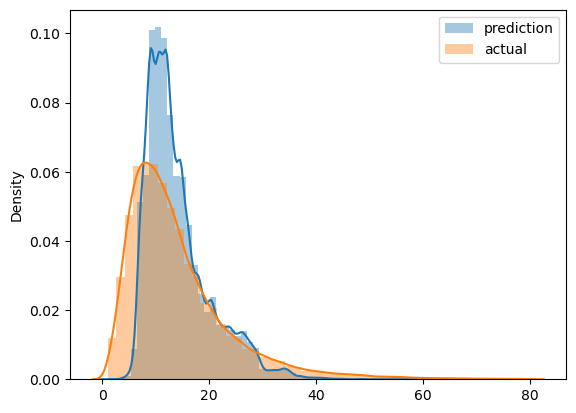

In [22]:
sns.distplot(y_pred, label="prediction")
sns.distplot(y_train, label="actual")

plt.legend()

In [23]:
mean_squared_error(y_train, y_pred, squared=False)

7.7023084859423365

/tmp/ipykernel_8861/3483418046.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_val, label="prediction")
/home/codespace/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_8861/3483418046.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level

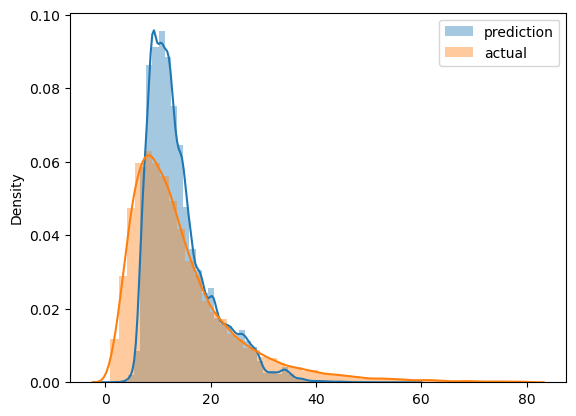

In [24]:
sns.distplot(y_pred_val, label="prediction")
sns.distplot(y_val, label="actual")

plt.legend()

In [25]:
mean_squared_error(y_pred_val, y_val, squared=False)

8.269106145230696

In [26]:
with open("models/lin_reg.bin", "wb") as f_out:
    pickle.dump((dv, lr), f_out)